In [1]:

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.


library("aws.s3")
obj <- get_object(
    object = "flavors_of_cacao.csv",
    bucket = "probabilityandstatisticsfordatasc-donotdelete-pr-duorunlizx3ipe",
    key = "87fb58e4105e4fe7b4d34eff52f1f4d4",
    secret = "98a9f85777140787c0b7aa67568c0984b1f08fcca6aab1a7",
    check_region = FALSE,
    base_url = "s3-api.us-geo.objectstorage.service.networklayer.com")

chocolateData <- read.csv(text = rawToChar(obj))

In [2]:
head(chocolateData, 10)

Company...Maker.if.known.,Specific.Bean.Origin.or.Bar.Name,REF,Review.Date,Cocoa.Percent,Company.Location,Rating,Bean.Type,Broad.Bean.Origin
A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela
A. Morin,Cuba,1315,2014,70%,France,3.50,,Cuba
A. Morin,Sur del Lago,1315,2014,70%,France,3.50,Criollo,Venezuela
A. Morin,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela
A. Morin,Pablino,1319,2014,70%,France,4.00,,Peru


In [3]:
tail(chocolateData, 3)

,Company...Maker.if.known.,Specific.Bean.Origin.or.Bar.Name,REF,Review.Date,Cocoa.Percent,Company.Location,Rating,Bean.Type,Broad.Bean.Origin
1793,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1794,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India
1795,Zotter,"Brazil, Mitzi Blue",486,2010,65%,Austria,3.00,,Brazil


### Exploring the Data

In [4]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Let's take a look at our data set using glimpse

In [5]:
glimpse(chocolateData)

Observations: 1,795
Variables: 9
$ Company...Maker.if.known.        <fct> A. Morin, A. Morin, A. Morin, A. Mor…
$ Specific.Bean.Origin.or.Bar.Name <fct> "Agua Grande", "Kpime", "Atsane", "A…
$ REF                              <int> 1876, 1676, 1676, 1680, 1704, 1315, …
$ Review.Date                      <int> 2016, 2015, 2015, 2015, 2015, 2014, …
$ Cocoa.Percent                    <fct> 63%, 70%, 70%, 70%, 70%, 70%, 70%, 7…
$ Company.Location                 <fct> France, France, France, France, Fran…
$ Rating                           <dbl> 3.75, 2.75, 3.00, 3.50, 3.50, 2.75, …
$ Bean.Type                        <fct>  ,  ,  ,  ,  , Criollo,  , Criollo, …
$ Broad.Bean.Origin                <fct> Sao Tome, Togo, Togo, Togo, Peru, Ve…


 Looks like we have 9 variables and 1,795 observations...

 Let's see how the ratings break down by country.

In [6]:
country_comparison <- chocolateData %>%
  group_by(Company.Location) %>%
  summarize(rating = mean(Rating), count = n()) %>%
  arrange(desc(count),desc(rating));

head(country_comparison, n = 10)

Company.Location,rating,count
U.S.A.,3.154123,764
France,3.251603,156
Canada,3.324000,125
U.K.,3.054688,96
Italy,3.325397,63
Ecuador,3.009259,54
Australia,3.357143,49
Belgium,3.093750,40
Switzerland,3.342105,38
Germany,3.178571,35


### Generating null and alternate hypotheses


Belgium and Switzerland are both known as producers of premium chocolate, and I'm surprised to see that Switzerland has noticibly higher ratings. Using bootstrapping methods, we can determine the probability of a difference this large occurring completely by chance. As an alternate hypothesis, let's postulate that Swiss chocolate is indeed better than Belgian chocolate. Conversely, our null hypothesis will be that the two countries are equivalent in their quality of and this difference has occurred at random.

First, let's filter the ratings so that we are only evaluating chocolate produced in Belgium or Switzerland. Then, we can plot the distribution or ratings across both countries.

In [7]:
library(ggplot2) 

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Warning message:
“Ignoring unknown parameters: text”

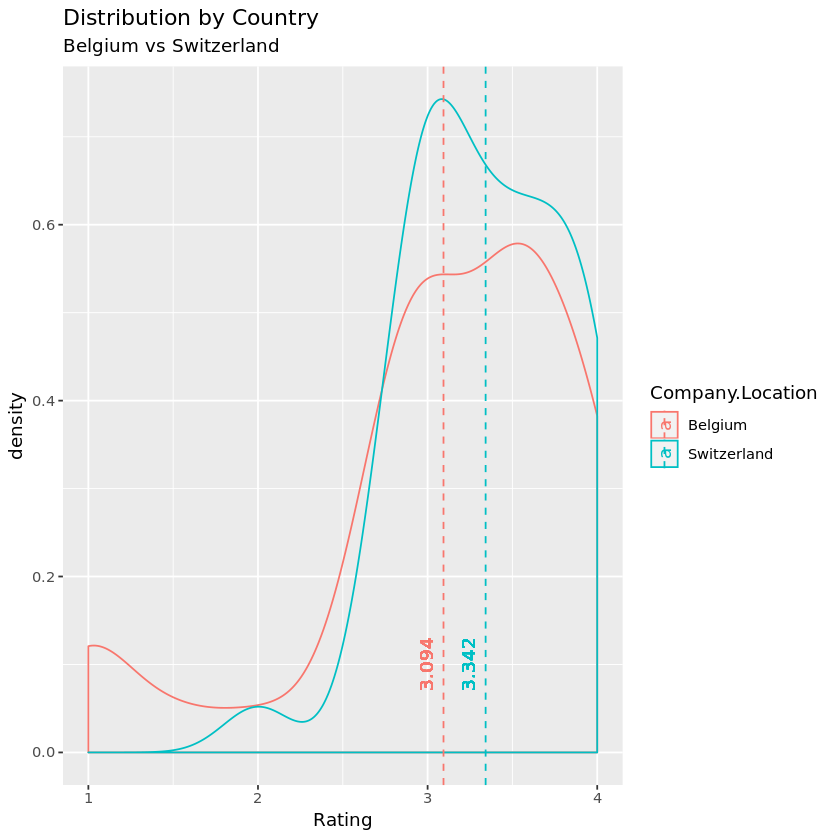

In [8]:
chocolateData %>% 
    filter(Company.Location %in% c("Belgium","Switzerland")) %>%
    group_by(Company.Location) %>%
    mutate(country_mean = mean(Rating)) %>%
    ggplot(aes(x = Rating, color = Company.Location)) +
    geom_density() +
    geom_vline(aes(xintercept = country_mean, color = Company.Location), linetype = "dashed") +
    geom_text(aes(x=country_mean - .1, y=.1, label=round(country_mean, 3)), angle=90, text=element_text(size=11)) +
    ggtitle("Distribution by Country", subtitle="Belgium vs Switzerland")

It looks like both countries have a relativly similar distribution of ratings. However, Belgium seems to have a cluster of low ratings that are pulling down the average.



### Replicate and Resample

Our goal is to resample the ratings in our data to simulate a random distribution of ratings where any relationship that might exist between country and rating is effectively broken. The process of randomly shuffling the datum is more effective if it is spread out across multiple copies (or permutations) of the data.

The first step to accomplishing this is to create a function that will create copies of our data. The repr function, defined below, takes in a dataframe and an integer representing the number of copies to make. It also appends an integer to each record indicating which copy of the data it belongs to.

In [9]:
repr <- function(df, r)
{
  copy <- data.frame()
  for (replication in 1:r)
  {
    df$rep <- replication
    copy <- rbind(df,copy)
  }
  copy
}

Here, we start with the choco data.frame, and filter it so that it only contains ratings from Belgium and Switzerland. We then create a 1000 copies of that data. Once that is finished, we create the Rating.Perm column, which is based on a random shuffling of the Rating column. Finally, we group by rep (copy number) and Company.Location, and save the result to the variable named choco_perm.



In [10]:
set.seed(321)
chocolateData_perm <- chocolateData %>% 
  filter(Company.Location %in% c("Belgium","Switzerland")) %>%
  repr(1000) %>%
  mutate(Rating.Perm = sample(Rating, replace = T)) %>%
  group_by(rep, Company.Location)

Once we have the choco_perm data.frame, we can calculate the average ratings in each copy (or permutation) of the data. As you can see, the original mean is also preserved, which makes it easy to compare to the new resampled mean. We will do this in the next step.



In [11]:
chocolateData_perm %>%
    summarize(orig_mean = mean(Rating), perm_mean = mean(Rating.Perm)) %>%
    head(n = 10)

rep,Company.Location,orig_mean,perm_mean
1,Belgium,3.093750,3.318750
1,Switzerland,3.342105,3.171053
2,Belgium,3.093750,3.300000
2,Switzerland,3.342105,3.335526
3,Belgium,3.093750,3.012500
3,Switzerland,3.342105,3.072368
4,Belgium,3.093750,3.262500
4,Switzerland,3.342105,3.447368
5,Belgium,3.093750,3.093750
5,Switzerland,3.342105,3.171053


Here, we again pipe choco_perm into summarize to get the mean rating in each group. We then pipe that result into summarize to get the difference between the original mean and each permutation mean.




In [12]:
chocolateData_diff <- chocolateData_perm %>%
    summarize(orig_mean = mean(Rating), perm_mean = mean(Rating.Perm)) %>%
    summarize(diff_rating = diff(orig_mean), diff_rating_perm = diff(perm_mean))

head(chocolateData_diff, n = 5)

rep,diff_rating,diff_rating_perm
1,0.2483553,-0.14769737
2,0.2483553,0.03552632
3,0.2483553,0.05986842
4,0.2483553,0.18486842
5,0.2483553,0.07730263


### Plot the Differences

Let's see where how difference from our original data.frame compares to the differences in our resampled data.



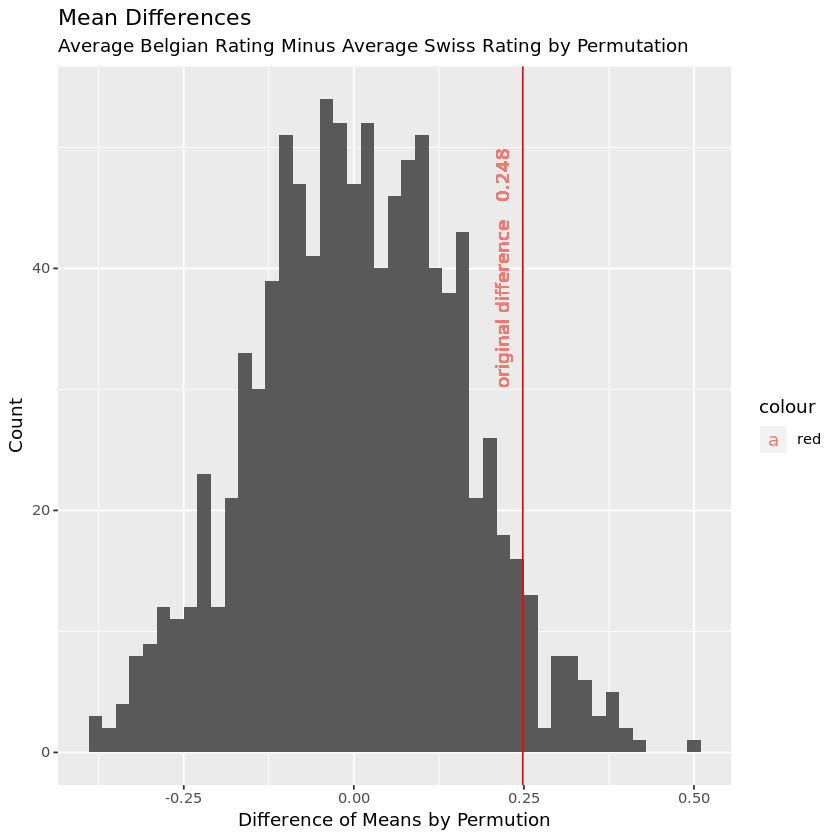

In [13]:
ggplot(chocolateData_diff, aes(x = diff_rating_perm)) +
  geom_histogram(binwidth = .02) +
  geom_vline(aes(xintercept = diff_rating), col = "red") +
  geom_text(aes(x=diff_rating - .03, y = 40, label = paste("original difference  ", round(diff_rating, 3)), color = "red", angle=90)) +
  ggtitle("Mean Differences", subtitle = "Average Belgian Rating Minus Average Swiss Rating by Permutation") +
  xlab("Difference of Means by Permution") +
  ylab("Count")

It looks like our difference is fairly far to the right in comparison to the distribution of resampled means, which indicates that a difference this large is not very likely to happen at random.

Exactly how unlikely is it? -- Let's calculate the p-value.



In [14]:
(p_value <- chocolateData_diff %>% summarize(mean(diff_rating <= diff_rating_perm)))

mean(diff_rating <= diff_rating_perm)
0.053


#### Conclusion

The above p-value indicates that less than 1 in 20 of our resampled means were greater than the difference found in our original dataset. This marginally clears the 0.05 confidence interval that typically denotes some level of statistical significance. Furthermore, while this doesn't completely rule out the possiblity that the ratings favored Switzerland by chance, it does indicate that additional investigation may be warranted.